In [1]:
import pandas as pd
import numpy as np

In [2]:
dataframe = pd.read_csv('datasets/housing.csv')

In [3]:
dataframe.info

<bound method DataFrame.info of        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  

In [4]:
dataframe['income_category'] = pd.cut(dataframe["median_income"],
                                      bins=[0,1.5,3.0,4.5,6.0,np.inf],
                                      labels=[1,2,3,4,5])

In [5]:
dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_category
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,2
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,2
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,2
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,2


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_stratified, test_stratified = train_test_split(dataframe, test_size=0.2, stratify = dataframe['income_category'],random_state=42)

In [8]:
for set_ in (train_stratified, test_stratified):
    set_.drop("income_category", axis=1, inplace=True)

In [9]:
train_stratified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [10]:
housing = train_stratified.drop("median_house_value", axis=1) 
housing_labels = train_stratified["median_house_value"].copy()

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [12]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [13]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

In [14]:
housing_num = housing.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

In [15]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

In [16]:
housing_prepared = full_pipeline.fit_transform(housing)

In [17]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

#param_grid = [
        #{'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
       # {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         #'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
   # ]

#svm_reg = SVR()
#grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
#grid_search.fit(housing_prepared, housing_labels)

In [18]:
 #grid_search.best_params_

In [19]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [20]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
print(lin_mse)

4709785076.060028


In [21]:
from sklearn.metrics import mean_squared_error
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018743

In [22]:
from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49438.66860915801

In [23]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [24]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_mse

0.0

In [25]:
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [26]:
tree_mae = mean_absolute_error(housing_labels, housing_predictions)
tree_mae

0.0

In [27]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [28]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [29]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180666


In [30]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [31]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_mse

347848562.21341085

In [32]:
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18650.698705770003

In [33]:
forest_mae = mean_absolute_error(housing_labels, housing_predictions)
forest_mae

12061.519983648257

In [34]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_crossval_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_crossval_scores)

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


In [35]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
tree_rmse_crossval_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_crossval_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [36]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
lin_rmse_crossval_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_crossval_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180666


In [37]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear",C= 30000.0)
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_mse

4922257565.859142

In [38]:
svm_rmse = np.sqrt(svm_mse)
svm_rmse

70158.80248307508

In [39]:
svm_mae = mean_absolute_error(housing_labels, housing_predictions)
svm_mae

48011.63088323751

In [40]:
metrics = {
    'Linear Regression': {'RMSE': lin_rmse, 'MAE': lin_mae},
    'Decision Tree': {'RMSE': tree_rmse, 'MAE': tree_mae},
    'Random Forest': {'RMSE': forest_rmse, 'MAE': forest_mae},
    'SVR': {'RMSE': svm_rmse, 'MAE':svm_mae}
}

In [41]:
metrics_dataframe = pd.DataFrame(metrics).T

In [42]:
metrics_dataframe

,RMSE,MAE
Linear Regression,68627.873900,49438.668609
Decision Tree,0.000000,0.000000
Random Forest,18650.698706,12061.519984
SVR,70158.802483,48011.630883


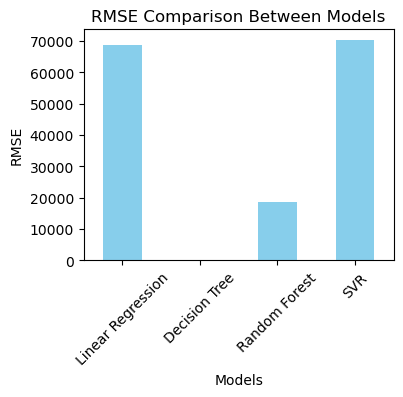

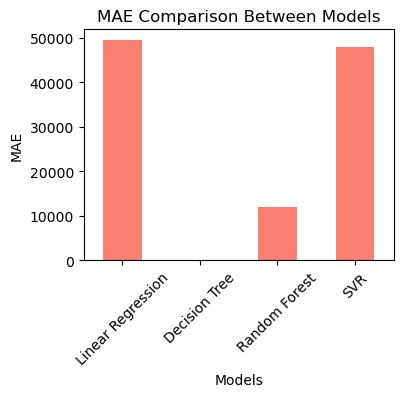

In [43]:
import matplotlib.pyplot as plt

# Plot histogram for RMSE
plt.figure(figsize=(4, 3))
metrics_dataframe['RMSE'].plot(kind='bar', color='skyblue')
plt.title('RMSE Comparison Between Models')
plt.ylabel('RMSE')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.show()

# Plot histogram for MAE
plt.figure(figsize=(4, 3))
metrics_dataframe['MAE'].plot(kind='bar', color='salmon')
plt.title('MAE Comparison Between Models')
plt.ylabel('MAE')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.show()


In [44]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
svm_rmse_crossval_scores = np.sqrt(-scores)

In [45]:
display_scores(svm_rmse_crossval_scores)

Scores: [72585.99458414 66004.56577084 67153.96597477 70209.98375934
 67114.11045891 73913.7945411  77198.45823317 69982.70788644
 67526.4418591  70919.95243819]
Mean: 70260.9975506008
Standard deviation: 3354.7386899231547


In [46]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_crossval_scores = np.sqrt(-scores)
display_scores(tree_rmse_crossval_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [47]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_crossval_scores = np.sqrt(-scores)
display_scores(lin_rmse_crossval_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180666


In [48]:
metrics = {
    'Linear Regression': {'RMSE': lin_rmse_crossval_scores},
    'Decision Tree': {'RMSE': tree_rmse_crossval_scores},
    'Random Forest': {'RMSE': forest_rmse_crossval_scores},
    'SVR': {'RMSE': svm_rmse_crossval_scores}
}

In [49]:
metrics_crossval_dataframe = pd.DataFrame(metrics).T

In [50]:
metrics_crossval_dataframe

,RMSE
Linear Regression,"[71762.76364394206, 64114.991663591, 67771.171..."
Decision Tree,"[72831.45749112035, 69973.18438321643, 69528.5..."
Random Forest,"[51559.633796383074, 48737.571000620606, 47210..."
SVR,"[72585.99458414373, 66004.56577084205, 67153.9..."


In [51]:
from sklearn.model_selection import cross_val_score

forest_crossval_mae_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_absolute_error", cv=10)
##forest_crossval_mae_scores = np.sqrt(-forest_crossval_scores)
display_scores(forest_crossval_mae_scores)

Scores: [-33037.9203632  -32177.03276029 -31584.31981829 -33503.8757662
 -31480.77631738 -33748.03454876 -33556.8454573  -33298.50469412
 -31743.14007268 -34154.43012114]
Mean: -32828.487991936796
Standard deviation: 939.2430190479434


In [52]:
from sklearn.model_selection import cross_val_score

lin_crossval_mae_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_absolute_error", cv=10)
##lin_crossval_mae_scores = np.sqrt(-lin_crossval_scores)
display_scores(lin_crossval_mae_scores)

Scores: [-51073.67938047 -47490.83379082 -47437.63430472 -49748.46418451
 -48317.02647654 -51366.01862714 -50783.2612851  -50614.66978571
 -48036.16866435 -50766.6692612 ]
Mean: -49563.44257605543
Standard deviation: 1493.5195373248425


In [53]:
from sklearn.model_selection import cross_val_score

tree_crossval_mae_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_absolute_error", cv=10)
##tree_crossval_mae_scores = np.sqrt(-tree_crossval_scores)
display_scores(tree_crossval_mae_scores)

Scores: [-45515.89830508 -45545.68159806 -43856.73712901 -46163.52089643
 -43769.68988492 -50604.04966687 -45249.04360993 -46169.99576015
 -44007.61538462 -44469.14778922]
Mean: -45535.13800242864
Standard deviation: 1896.7762983750138


In [54]:
from sklearn.model_selection import cross_val_score

svm_crossval_mae_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_absolute_error", cv=10)
##svm_crossval_mae_scores = np.sqrt(-svm_crossval_scores)
display_scores(svm_crossval_mae_scores)

Scores: [-49290.7895542  -46754.91094914 -45446.89219078 -48693.27863044
 -46444.8067437  -50071.96085742 -49787.06138198 -49155.08539675
 -46451.63437088 -48991.40277627]
Mean: -48108.7822851554
Standard deviation: 1572.1583065695131


In [55]:
metrics = {
    'Linear Regression': {'RMSE': lin_rmse_crossval_scores.mean(), 'MAE': -lin_crossval_mae_scores.mean()},
    'Decision Tree': {'RMSE': tree_rmse_crossval_scores.mean(), 'MAE': -tree_crossval_mae_scores.mean()},
    'Random Forest': {'RMSE': forest_rmse_crossval_scores.mean(), 'MAE': -forest_crossval_mae_scores.mean()},
    'SVR': {'RMSE': svm_rmse_crossval_scores.mean(), 'MAE': -svm_crossval_mae_scores.mean()}
}

In [56]:
metrics_crossval_dataframe = pd.DataFrame(metrics).T

In [57]:
metrics_crossval_dataframe

,RMSE,MAE
Linear Regression,69104.079982,49563.442576
Decision Tree,71629.890097,45535.138002
Random Forest,50435.580921,32828.487992
SVR,70260.997551,48108.782285


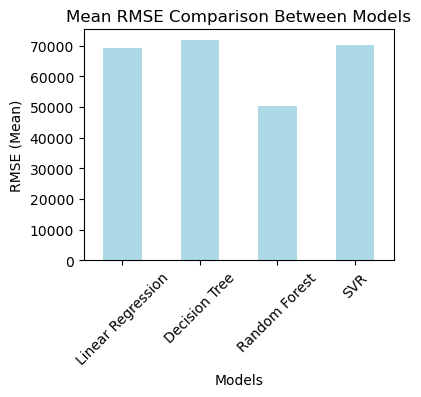

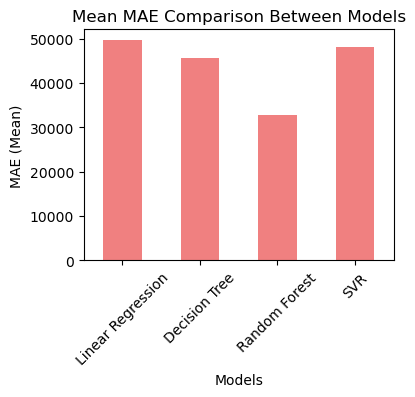

In [58]:
import matplotlib.pyplot as plt

# Plot histogram for RMSE
plt.figure(figsize=(4, 3))
metrics_crossval_dataframe['RMSE'].plot(kind='bar', color='lightblue')
plt.title('Mean RMSE Comparison Between Models')
plt.ylabel('RMSE (Mean)')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.show()

# Plot histogram for MAE
plt.figure(figsize=(4, 3))
metrics_crossval_dataframe['MAE'].plot(kind='bar', color='lightcoral')
plt.title('Mean MAE Comparison Between Models')
plt.ylabel('MAE (Mean)')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.show()



In [59]:
#Fine tuning the models

In [60]:
#grid Search

In [191]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_forest = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_forest.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [195]:
grid_search_forest.best_params_

{'max_features': 8, 'n_estimators': 30}

In [197]:
grid_search_forest.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [199]:
cvres_grid_forest = grid_search_forest.cv_results_
for mean_score, params in zip(cvres_grid_forest["mean_test_score"], cvres_grid_forest["params"]):
    print(np.sqrt(-mean_score), params)

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
52885.86715332332 {'max_features': 2, 'n_estimators': 30}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
62381.765106921855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54476.57050944266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59974.60028085155 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52754.5632813202 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

In [189]:
grid_search

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [65]:
#pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.082035,0.005575,0.003386,0.000501,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.119912e+09,-3.723465e+09,...,-4.082592e+09,1.867375e+08,18,-1.155630e+09,-1.089726e+09,-1.153843e+09,-1.118149e+09,-1.093446e+09,-1.122159e+09,2.834288e+07
1,0.225379,0.014916,0.009115,0.002051,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.973521e+09,-2.810319e+09,...,-3.015803e+09,1.139808e+08,11,-5.982947e+08,-5.904781e+08,-6.123850e+08,-5.727681e+08,-5.905210e+08,-5.928894e+08,1.284978e+07
2,0.683260,0.047821,0.022874,0.002258,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.801229e+09,-2.671474e+09,...,-2.796915e+09,7.980892e+07,9,-4.412567e+08,-4.326398e+08,-4.553722e+08,-4.320746e+08,-4.311606e+08,-4.385008e+08,9.184397e+06
3,0.120512,0.007760,0.003216,0.000767,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.528743e+09,-3.490303e+09,...,-3.609050e+09,1.375683e+08,16,-9.782368e+08,-9.806455e+08,-1.003780e+09,-1.016515e+09,-1.011270e+09,-9.980896e+08,1.577372e+07
4,0.404643,0.017811,0.009101,0.001381,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.742620e+09,-2.609311e+09,...,-2.755726e+09,1.182604e+08,7,-5.063215e+08,-5.257983e+08,-5.081984e+08,-5.174405e+08,-5.282066e+08,-5.171931e+08,8.882622e+06
5,1.194204,0.033365,0.024504,0.003365,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.522176e+09,-2.440241e+09,...,-2.518759e+09,8.488084e+07,3,-3.776568e+08,-3.902106e+08,-3.885042e+08,-3.830866e+08,-3.894779e+08,-3.857872e+08,4.774229e+06
6,0.160168,0.009011,0.002998,0.000634,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.362127e+09,-3.311863e+09,...,-3.371513e+09,1.378086e+08,13,-8.909397e+08,-9.583733e+08,-9.000201e+08,-8.964731e+08,-9.151927e+08,-9.121998e+08,2.444837e+07
7,0.534015,0.012509,0.009309,0.002350,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.622099e+09,-2.669655e+09,...,-2.654240e+09,6.967978e+07,5,-4.939906e+08,-5.145996e+08,-5.023512e+08,-4.959467e+08,-5.147087e+08,-5.043194e+08,8.880106e+06
8,1.638398,0.049573,0.023058,0.003118,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.446142e+09,-2.446594e+09,...,-2.496981e+09,7.357046e+07,2,-3.760968e+08,-3.876636e+08,-3.875307e+08,-3.760938e+08,-3.861056e+08,-3.826981e+08,5.418747e+06
9,0.214354,0.017318,0.003130,0.000639,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.590333e+09,-3.232664e+09,...,-3.468718e+09,1.293758e+08,14,-9.505012e+08,-9.166119e+08,-9.033910e+08,-9.070642e+08,-9.459386e+08,-9.247014e+08,1.973471e+07


In [209]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'max_depth': [3, 10, None], 
     'min_samples_split': [2, 10, 20],
     'min_samples_leaf': [1, 5, 10],
     'max_features': [None, 'sqrt', 'log2']}
]

tree_reg = DecisionTreeRegressor(random_state=42)

grid_search_tree = GridSearchCV(tree_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_tree.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid=[{'max_depth': [3, 10, None],
                          'max_features': [None, 'sqrt', 'log2'],
                          'min_samples_leaf': [1, 5, 10],
                          'min_samples_split': [2, 10, 20]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [202]:
grid_search_tree.best_params_

{'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2}

In [205]:
grid_search_tree.best_estimator_

DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, random_state=42)

In [221]:
cvres_grid_tree = grid_search_tree.cv_results_
for mean_score, params in zip(cvres_grid_tree["mean_test_score"], cvres_grid_tree["params"]):
    print(np.sqrt(-mean_score), params)

75687.40458065865 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
75687.40458065865 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
75687.40458065865 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 20}
75687.40458065865 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
75687.40458065865 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 10}
75687.40458065865 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 20}
75687.40458065865 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
75687.40458065865 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 10}
75687.40458065865 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 20}
88370.99321119268 {'max_depth': 3, 'max_features': 'sqr

In [69]:
#SVR 

In [219]:
param_grid = [
    {'kernel': ['linear', 'rbf'],        # Try linear and RBF kernels
     'C': [0.1, 1, 10, 100],             # Regularization parameter
     'gamma': ['scale', 'auto'],         # Kernel coefficient
     'epsilon': [0.1, 0.2, 0.5]}         # Epsilon parameter
]

svr_reg = SVR()

grid_search_svr = GridSearchCV(svr_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_svr.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.1, 1, 10, 100], 'epsilon': [0.1, 0.2, 0.5],
                          'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [223]:
grid_search_svr.best_params_

{'C': 100, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

In [227]:
grid_search_svr.best_estimator_

SVR(C=100, kernel='linear')

In [229]:
cvres_grid_svr = grid_search_svr.cv_results_
for mean_score, params in zip(cvres_grid_svr["mean_test_score"], cvres_grid_svr["params"]):
    print(np.sqrt(-mean_score), params)

118258.82445795466 {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
118905.81399396772 {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
118258.82445795466 {'C': 0.1, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
118905.98565388561 {'C': 0.1, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
118258.82445795466 {'C': 0.1, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'linear'}
118905.81399396772 {'C': 0.1, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}
118258.82445795466 {'C': 0.1, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'linear'}
118905.98565388561 {'C': 0.1, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf'}
118258.82445795464 {'C': 0.1, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
118905.81399396772 {'C': 0.1, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}
118258.82445795464 {'C': 0.1, 'epsilon': 0.5, 'gamma': 'auto', 'kernel': 'linear'}
118905.98637093464 {'C': 0.1, 'epsilon': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}
112571.063786057

In [73]:
#Linear Regressor

In [281]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define a parameter grid for Ridge regression
param_grid_ridge = [
    {'alpha': [0.1, 1.0, 10.0, 100.0]}
]

# Use Ridge instead of LinearRegression
ridge_reg = Ridge()

# Set up GridSearchCV
grid_search_linear = GridSearchCV(ridge_reg, param_grid_ridge, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

# Fit the model to your data
grid_search_linear.fit(housing_prepared, housing_labels)

# To see the best parameters found by GridSearchCV
print("Best parameters:", grid_search.best_params_)

# To see the best estimator
best_ridge = grid_search.best_estimator_

Best parameters: {'alpha': 10.0}


In [283]:
grid_search_linear.best_params_

{'alpha': 10.0}

In [285]:
grid_search_linear.best_estimator_

Ridge(alpha=10.0)

In [307]:
cvres_grid_linear = grid_search_linear.cv_results_
for mean_score, params in zip(cvres_grid_linear["mean_test_score"], cvres_grid_linear["params"]):
    print(np.sqrt(-mean_score), params)

69077.26727067142 {'alpha': 0.1}
69076.70631028558 {'alpha': 1.0}
69070.40042665186 {'alpha': 10.0}
69077.18726828667 {'alpha': 100.0}


In [109]:
#Random search

In [111]:
#Random Forest Regressor

In [117]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search_forest = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search_forest.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000147A5137650>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000147A5134050>},
                   random_state=42, scoring='neg_mean_squared_error')

In [237]:
cvres_rnd_forest = rnd_search_forest.cv_results_
for mean_score, params in zip(cvres_forest["mean_test_score"], cvres_forest["params"]):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


In [137]:
#Decison Tree regressor Random search

In [147]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'max_depth': randint(low=2, high=12),
        'min_samples_leaf': randint(low=2, high=12),
    }

tree_reg = DecisionTreeRegressor(random_state=42)
rnd_search_tree = RandomizedSearchCV(tree_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search_tree.fit(housing_prepared,housing_labels)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000147A5151FD0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000147A51521E0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [243]:
cvres_rnd_tree = rnd_search_tree.cv_results_
for mean_score, params in zip(cvres_tree["mean_test_score"], cvres_tree["params"]):
    print(np.sqrt(-mean_score), params)

61747.14375769412 {'max_depth': 8, 'min_samples_leaf': 5}
60478.42962221465 {'max_depth': 9, 'min_samples_leaf': 6}
61512.95778321943 {'max_depth': 8, 'min_samples_leaf': 11}
70399.04126951062 {'max_depth': 4, 'min_samples_leaf': 8}
60478.42962221465 {'max_depth': 9, 'min_samples_leaf': 6}
67683.83274888521 {'max_depth': 5, 'min_samples_leaf': 9}
60856.93193131389 {'max_depth': 9, 'min_samples_leaf': 4}
62721.03517494466 {'max_depth': 7, 'min_samples_leaf': 6}
75687.40458065865 {'max_depth': 3, 'min_samples_leaf': 9}
63035.98363684648 {'max_depth': 7, 'min_samples_leaf': 3}


In [157]:
#SVr random search

In [153]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'C': randint(low=50, high=130),
        'kernel': ["linear"],
    }

svr_reg = SVR()
rnd_search_svr = RandomizedSearchCV(svr_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search_svr.fit(housing_prepared,housing_labels)

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000147A5153E90>,
                                        'kernel': ['linear']},
                   random_state=42, scoring='neg_mean_squared_error')

In [247]:
cvres_rnd_svr = rnd_search_svr.cv_results_
for mean_score, params in zip(cvres_svr["mean_test_score"], cvres_svr["params"]):
    print(np.sqrt(-mean_score), params)

71617.25677032958 {'C': 101, 'kernel': 'linear'}
72546.02495521246 {'C': 64, 'kernel': 'linear'}
71368.85229454024 {'C': 121, 'kernel': 'linear'}
71498.47037225339 {'C': 110, 'kernel': 'linear'}
72336.01955312426 {'C': 70, 'kernel': 'linear'}
71350.20285199532 {'C': 124, 'kernel': 'linear'}
71350.20285199532 {'C': 124, 'kernel': 'linear'}
72240.00302608592 {'C': 73, 'kernel': 'linear'}
73127.97179169115 {'C': 52, 'kernel': 'linear'}
72307.20815191719 {'C': 71, 'kernel': 'linear'}


In [159]:
#Linear Regressor Random search

In [299]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'alpha': randint(low=2, high=12),
}

ridge_reg = Ridge()
rnd_search_ridge = RandomizedSearchCV(ridge_reg, param_distributions=param_distribs,
                                      n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search_ridge.fit(housing_prepared, housing_labels)


RandomizedSearchCV(cv=5, estimator=Ridge(),
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000147C8D82B10>},
                   random_state=42, scoring='neg_mean_squared_error')

In [301]:
cvres_rnd_ridge = rnd_search_ridge.cv_results_
for mean_score, params in zip(cvres_rnd_ridge["mean_test_score"], cvres_rnd_ridge["params"]):
    print(np.sqrt(-mean_score), params)

69071.69451056884 {'alpha': 8}
69073.7888680718 {'alpha': 5}
69071.03666840933 {'alpha': 9}
69073.07209675347 {'alpha': 6}
69071.69451056884 {'alpha': 8}
69069.78609066925 {'alpha': 11}
69074.5203509251 {'alpha': 4}
69071.69451056884 {'alpha': 8}
69071.03666840933 {'alpha': 9}
69073.07209675347 {'alpha': 6}


In [ ]:
#Combining RMSE values into one dataframe for plotting charts

In [309]:
import pandas as pd
import numpy as np

rmse_forest = np.sqrt(-cvres_grid_forest['mean_test_score'])
rmse_tree = np.sqrt(-cvres_grid_tree['mean_test_score'])
rmse_svr = np.sqrt(-cvres_grid_svr['mean_test_score'])
rmse_linear = np.sqrt(-cvres_grid_linear['mean_test_score'])

# dataFrame to hold the RMSE values and corresponding model names
results_grid = pd.DataFrame({
    'RMSE': np.concatenate([rmse_forest, rmse_tree, rmse_svr, rmse_linear]),
    'Model': ['Random Forest'] * len(rmse_forest) + \
             ['Decision Tree'] * len(rmse_tree) + \
             ['Support Vector Regressor'] * len(rmse_svr) + \
             ['Linear Regressor'] * len(rmse_linear)
})

print(results_grid)


             RMSE                     Model
0    63895.161578             Random Forest
1    54916.323863             Random Forest
2    52885.867153             Random Forest
3    60075.368033             Random Forest
4    52495.012850             Random Forest
..            ...                       ...
146  97940.318576  Support Vector Regressor
147  69077.267271          Linear Regressor
148  69076.706310          Linear Regressor
149  69070.400427          Linear Regressor
150  69077.187268          Linear Regressor

[151 rows x 2 columns]


In [311]:
import pandas as pd
import numpy as np

rmse_forest_rnd = np.sqrt(-cvres_rnd_forest['mean_test_score'])
rmse_tree_rnd = np.sqrt(-cvres_rnd_tree['mean_test_score'])
rmse_svr_rnd = np.sqrt(-cvres_rnd_svr['mean_test_score'])
rmse_linear_rnd = np.sqrt(-cvres_rnd_ridge['mean_test_score'])

#dataFrame to hold the RMSE values and corresponding model names
results_rnd = pd.DataFrame({
    'RMSE': np.concatenate([rmse_forest_rnd, rmse_tree_rnd, rmse_svr_rnd, rmse_linear_rnd]),
    'Model': ['Random Forest'] * len(rmse_forest_rnd) + \
             ['Decision Tree'] * len(rmse_tree_rnd) + \
             ['Support Vector Regressor'] * len(rmse_svr_rnd) + \
             ['Linear Regressor'] * len(rmse_linear_rnd)
})

print(results_rnd)


            RMSE                     Model
0   49117.553443             Random Forest
1   51450.632029             Random Forest
2   50692.535882             Random Forest
3   50783.614494             Random Forest
4   49162.898775             Random Forest
5   50655.798471             Random Forest
6   50513.856320             Random Forest
7   49521.172020             Random Forest
8   50302.904408             Random Forest
9   65167.020186             Random Forest
10  61747.143758             Decision Tree
11  60478.429622             Decision Tree
12  61512.957783             Decision Tree
13  70399.041270             Decision Tree
14  60478.429622             Decision Tree
15  67683.832749             Decision Tree
16  60856.931931             Decision Tree
17  62721.035175             Decision Tree
18  75687.404581             Decision Tree
19  63035.983637             Decision Tree
20  71617.256770  Support Vector Regressor
21  72546.024955  Support Vector Regressor
22  71368.8

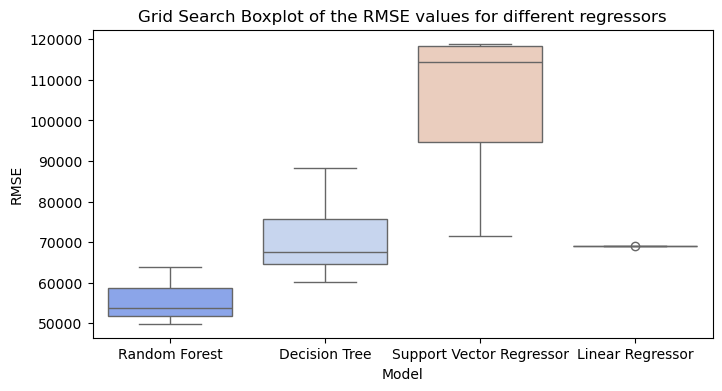

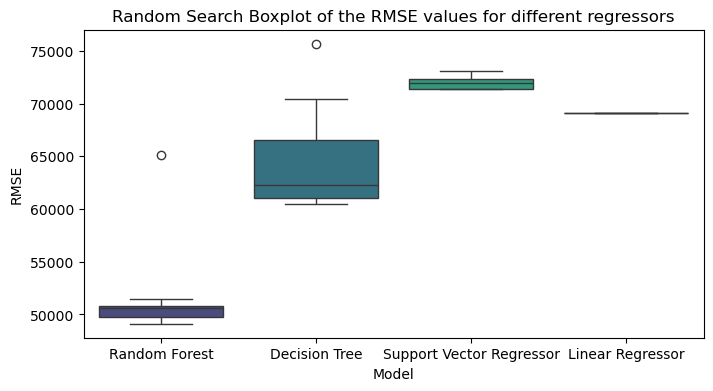

In [337]:
import seaborn as sns
import matplotlib.pyplot as plt

# Box plot for Grid Search results with updated palette handling
plt.figure(figsize=(8, 4))
sns.boxplot(x='Model', y='RMSE', data=results_grid, hue='Model', palette='coolwarm', dodge=False)
plt.title('Grid Search Boxplot of the RMSE values for different regressors')
plt.legend([],[], frameon=False)  # Hide the legend
plt.show()

# Box plot for Random Search results with updated palette handling
plt.figure(figsize=(8, 4))
sns.boxplot(x='Model', y='RMSE', data=results_rnd, hue='Model', palette='viridis', dodge=False)
plt.title('Random Search Boxplot of the RMSE values for different regressors')
plt.legend([],[], frameon=False)  # Hide the legend
plt.show()



In [ ]:
#Test set evaluation
#Grid search random forest regressor

In [319]:
final_model = grid_search_forest.best_estimator_

X_test =test_stratified.drop("median_house_value", axis=1)
y_test = test_stratified["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [265]:
print(final_rmse)

47873.26095812988


In [275]:
#Test set evaluation
#random search random forest regressor

In [321]:
final_model = rnd_search_forest.best_estimator_

X_test =test_stratified.drop("median_house_value", axis=1)
y_test = test_stratified["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse_rnd = np.sqrt(final_mse)

In [273]:
print(final_rmse_rnd)

46981.841079394515
